In [17]:
import xarray as xr 

ds = xr.open_dataset('soil-water-forecasting/modeling-pipeline/data/02_intermediate/preprocessed_data.nc', chunks="auto")

In [18]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:     (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-11-01
  * latitude    (latitude) int64 1kB -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude   (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Data variables: (12/24)
    swvl1       (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...          ...
    lsm         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    si10        (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    e           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [19]:
# Update swvl1: Set to 1 wherever lsm indicates water (lsm == 1)
ds['swvl1'] = ds['swvl1'].where(ds['lsm'] != 0, other=1)

In [20]:
# Save the original attributes
original_attrs = ds['tp'].attrs

# Perform the conversion
ds['tp'] = ds['tp'] * 1000

# Restore the original attributes and update the units
ds['tp'].attrs = original_attrs
ds['tp'].attrs['units'] = 'mm'  # Update the units attribute to 'mm'

In [21]:
# Save the original attributes
original_attrs = ds['pev'].attrs

# Perform the conversion
ds['pev'] = ds['pev'] * 1000

# Restore the original attributes and update the units
ds['pev'].attrs = original_attrs
ds['pev'].attrs['units'] = 'mm'  # Update the units attribute to 'mm'

# Anomalies

In [22]:
# Feature engineering

import xarray as xr
import numpy as np
from typing import Tuple

def calculate_standardized_anomalies(
    ds: xr.Dataset, 
    variable: str, 
    date_range: Tuple[str, str]
) -> xr.Dataset:
    """
    Calculate standardized monthly anomalies for a specific variable,
    handling cases with zero standard deviation or NaNs.
    """
    # Ensure the variable exists
    if variable not in ds.variables:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")
    
    # Step 1: Filter dataset for the climatology period
    start_date, end_date = date_range
    ds_clim_period = ds.sel(valid_time=slice(start_date, end_date))
    
    # Step 2: Extract the variable and calculate monthly climatology (mean and std)
    data_clim_period = ds_clim_period[variable]
    climatology_mean = data_clim_period.groupby('valid_time.month').mean('valid_time')
    climatology_std = data_clim_period.groupby('valid_time.month').std('valid_time')

    # Replace zero standard deviation with a small number
    climatology_std = climatology_std.where(climatology_std > 0, other=1e-10)

    # Step 3: Calculate standardized anomalies for all valid_time in the original dataset
    data_full = ds[variable]
    standardized_anomalies = xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
        data_full.groupby('valid_time.month'),
        climatology_mean,
        climatology_std,
        dask="allowed"
    )

    # Step 4: Add standardized anomalies to the original dataset
    ds_standardized_anomalies = ds.copy()
    ds_standardized_anomalies[f"{variable}_std_anomaly"] = standardized_anomalies

    return ds_standardized_anomalies


In [23]:
# Example Usage
date_range = ("1979-01-01", "2019-12-31")

ds = calculate_standardized_anomalies(ds, variable='tp', date_range=date_range)

# ds = calculate_standardized_anomalies(ds, variable='swvl1', date_range=date_range)

# ds = calculate_standardized_anomalies(ds, variable='pev', date_range=date_range)

Temporal Features

Lets add Seasonal Cycles

In [24]:
# Extract the season from the time coordinate
ds['season'] = ds['valid_time'].dt.season

In [25]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:         (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-11-01
  * latitude        (latitude) int64 1kB -90 -89 -88 -87 -86 ... 85 86 87 88 89
  * longitude       (longitude) int64 3kB 0 1 2 3 4 5 ... 355 356 357 358 359
    month           (valid_time) int64 4kB 1 2 3 4 5 6 7 8 ... 4 5 6 7 8 9 10 11
Data variables: (12/26)
    swvl1           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...              ...
    e               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_std_anomaly  (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    season          (valid_time) <U3 7kB 'DJF' 'DJF' 'MAM' ... 'SON' 'SON' 'SON'
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [26]:
# Define a dictionary to map season strings to numerical values
season_mapping = {'DJF': 1, 'MAM': 2, 'JJA': 3, 'SON': 4}

# Convert the DataArray to a pandas Series, map the season names, and convert back to a DataArray
ds['season'] = ds['season'].to_series().map(season_mapping).to_xarray()

In [27]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:         (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-11-01
  * latitude        (latitude) int64 1kB -90 -89 -88 -87 -86 ... 85 86 87 88 89
  * longitude       (longitude) int64 3kB 0 1 2 3 4 5 ... 355 356 357 358 359
    month           (valid_time) int64 4kB 1 2 3 4 5 6 7 8 ... 4 5 6 7 8 9 10 11
Data variables: (12/26)
    swvl1           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...              ...
    e               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_std_anomaly  (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    season          (valid_time) int64 4kB 1 1 2 2 2 3 3 3 4 ... 2 2 3 3 3 4 4 4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [28]:
# Broadcast 'season' to match dimensions (date, latitude, longitude)
season_broadcasted = ds['season'].expand_dims({'latitude': ds.latitude, 'longitude': ds.longitude})

# Add this expanded 'season' variable back to the dataset
ds['season'] = season_broadcasted

# Transpose 'season' to match the desired dimensions (date, latitude, longitude)
ds['season'] = ds['season'].transpose('valid_time', 'latitude', 'longitude')

In [29]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:         (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-11-01
  * latitude        (latitude) int64 1kB -90 -89 -88 -87 -86 ... 85 86 87 88 89
  * longitude       (longitude) int64 3kB 0 1 2 3 4 5 ... 355 356 357 358 359
    month           (valid_time) int64 4kB 1 2 3 4 5 6 7 8 ... 4 5 6 7 8 9 10 11
Data variables: (12/26)
    swvl1           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...              ...
    e               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_std_anomaly  (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    season          (valid_time, latitude, longitude) int64 286MB 1 1 1 ... 4 4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [30]:
# Convert season to int8
ds['season'] = ds['season'].astype('int32')

In [31]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:         (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-11-01
  * latitude        (latitude) int64 1kB -90 -89 -88 -87 -86 ... 85 86 87 88 89
  * longitude       (longitude) int64 3kB 0 1 2 3 4 5 ... 355 356 357 358 359
    month           (valid_time) int64 4kB 1 2 3 4 5 6 7 8 ... 4 5 6 7 8 9 10 11
Data variables: (12/26)
    swvl1           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...              ...
    e               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp              (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev             (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_std_anomaly  (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    season          (valid_time, latitude, longitude) int32 143MB 1 1 1 ... 4 4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

tp_minus_E_cumulative total precipitation minus evaportaion 

calaculate specific humidity from 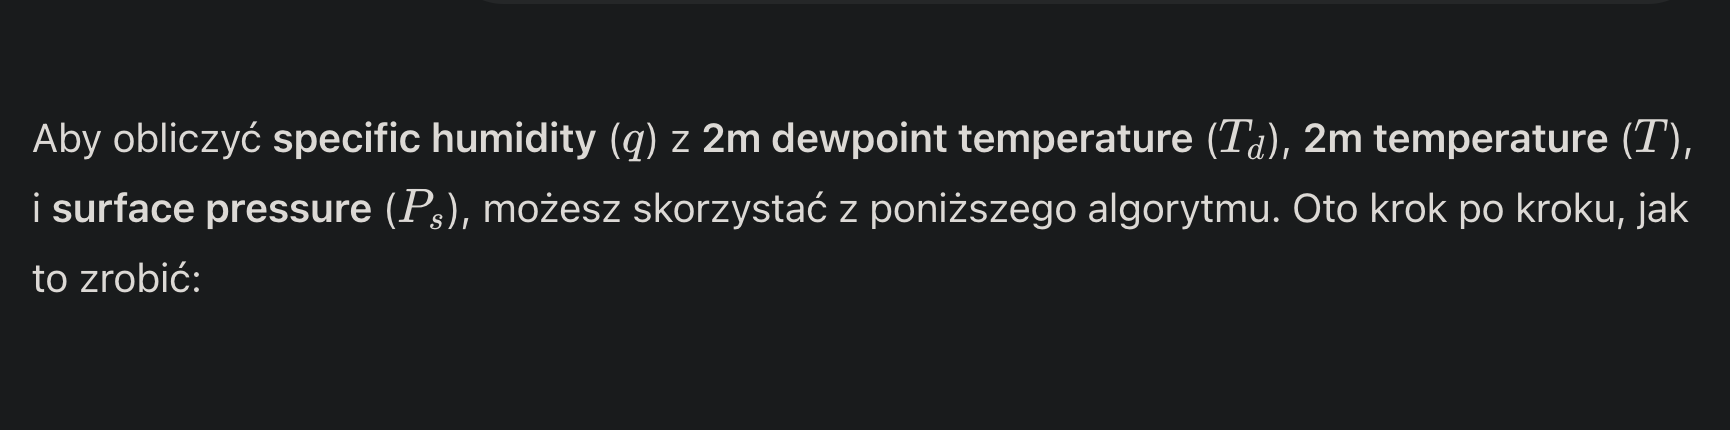
 

Soil Moisture Dynamics

Evapotranspiration Balance: Calculate a moisture balance feature as tp - e (precipitation minus evaporation). This balance can serve as an indicator of moisture availability and stress, especially over rolling windows.

Wind Impact: Combine u10 and v10 (wind components) to create a wind speed variable to assess the drying effect of wind on soil moisture.

Determine Wind Direction: Calculate the wind direction using: Wind speed and direction influence evapotranspiration rates, affecting soil moisture levels.

Temperature Anomalies: Identify deviations from long-term average temperatures to capture unusual thermal conditions impacting soil moisture.

In [32]:
ds.to_netcdf('soil-water-forecasting/modeling-pipeline/data/04_feature/features.nc')